# HW#7 RNN

안녕하세요, 광운대학교 로봇학부의 오정현 교수입니다. 본 자료는 딥러닝 실습 수업을 위해 제작된 것입니다.

파이썬 문법
- 점프투파이썬(https://wikidocs.net/book/1) 참고

이번 과제는 딥러닝의 대표적인 구조인 Recurrent Neural Network (RNN)을 이용하여 주가 예측을 해보도록 하겠습니다. 이번 과제를 통해 부자가 되는 길(?)을 찾으면 좋겠네요.

#1. Data Import
Data는 yahoo finance에서 제공하는 api를 통해 가져올 수 있습니다. https://finance.yahoo.com/에 접속해서 원하는 종목을 검색하면 종목 코드를 알 수 있습니다. 종목 코드와 데이터를 가져올 시작 날짜와 끝 날짜를 입력하면 주가에 대한 데이터를 가져올 수 있습니다. 이 데이터는 `pdr.DataReader('종목코드', 'yahoo', 시작날짜, 끝날짜)` 함수를 통해 가져올 수 있습니다.

예시) 삼성전자 주식 2000년 1월 1일부터 2010년 12월 31일까지 주가 정보 함수

dr.DataReader('005930.KS', 'yahoo', datetime(2000,1,1), datetime(2010,12,31))

애플 주식 2000년 1월 1일부터 2010년 12월 31일까지 주가를 학습데이터로 활용하고 2011년 1월 1일부터 2020년 5월 22일까지 주가를 테스트데이터로 활용해 봅시다.



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

### START CODE HERE ###
df_train = pdr.DataReader('AAPL', 'yahoo', datetime(2000,1,1), datetime(2010,12,31))
df_test = pdr.DataReader('AAPL', 'yahoo', datetime(2011,1,1), datetime(2020,5,22))
### END CODE HERE ###

training_set = df_train.iloc[:, 3:4].values
test_set = df_test.iloc[:, 3:4].values
#training_set.shape, test_set.shape
assert training_set.shape == (2767,1)
assert test_set.shape == (2363,1)

training data와 test data를 출력해보겠습니다.


Text(0, 0.5, 'price($)')

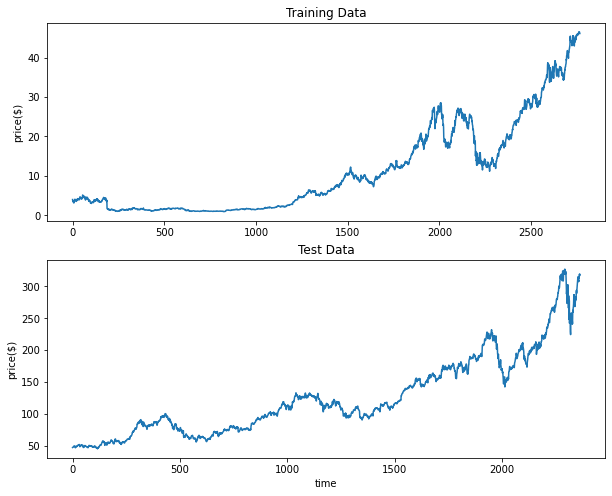

In [26]:
plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set)
plt.title("Training Data")
plt.ylabel('price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('price($)')

학습을 위하여 데이터를 0에서 1 사이의 값으로 scaling 해주도록 하겠습니다. 아래 코드를 실행하면 y축 값이 0에서 1 사이의 값으로 바뀌었음을 확인할 수 있습니다.

Text(0, 0.5, 'scaled price($)')

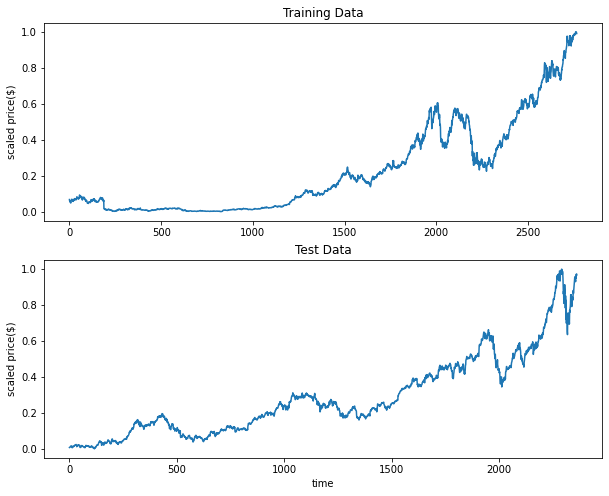

In [27]:
sc1 = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc1.fit_transform(training_set)
sc2 = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc2.fit_transform(test_set)

plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set_scaled)
plt.title("Training Data")
plt.ylabel('scaled price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set_scaled)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('scaled price($)')

이제 학습을 위해 데이터를 일정한 길이의 sequence로 나누도록 하겠습니다. 아래 코드를 통해 길이가 60인 sequence들로 이루어진 X와 그때의 데이터값 Y로 X_train, Y_train, X_test, Y_test 만들 수 있습니다.

In [0]:
X_train = []
Y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
Y_test = []
for i in range(60, test_set_scaled.shape[0]):
    X_test.append(test_set_scaled[i-60:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [29]:
X_test.shape

(2303, 60, 1)

이제 RNN 모델을 만들어보도록 하겠습니다. 아래 모델과 같이 레이어를 구성해 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| LSTM | (None, 60, 50) | 10400 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 60, 50) | 20200 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 60, 50) | 20200 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 50) | 20200 |
| Dropout | (None, 50) | 0 |
| Dense | (None, 1) | 51 |


In [30]:

import tensorflow as tf


### START CODE HERE ###
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM((50),input_shape = (60, 1),return_sequences=True),
                                    tf.keras.layers.Dropout(0.2),

                                    
                                    tf.keras.layers.LSTM(50,return_sequences=True),
                                    tf.keras.layers.Dropout(0.2),

                                    
                                    tf.keras.layers.LSTM(50,return_sequences=True),
                                    tf.keras.layers.Dropout(0.2),

                                    
                                    tf.keras.layers.LSTM(50),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Dense(1, activation= 'linear')
         

])


### END CODE HERE ###

model.summary()

Model: "sequential_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout_680 (Dropout)        (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_681 (Dropout)        (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_682 (Dropout)        (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)             

학습을 시작합니다.

In [31]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, Y_train, epochs = 10, batch_size = 128)

Epoch 1/10
22/22 [==============================] - 0s 15ms/step - loss: 0.0279
Epoch 2/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0036
Epoch 3/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0024
Epoch 4/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0022
Epoch 5/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0019
Epoch 6/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0018
Epoch 7/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0019
Epoch 8/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0018
Epoch 9/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 10/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0015


이제 training data의 prediction 결과와 test data의 prediction 결과를 살펴보겠습니다.

In [32]:
predicted_X_train = model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = model.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[59:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[59:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 0.6436900341691326
평균 test error: 4.990505052865509


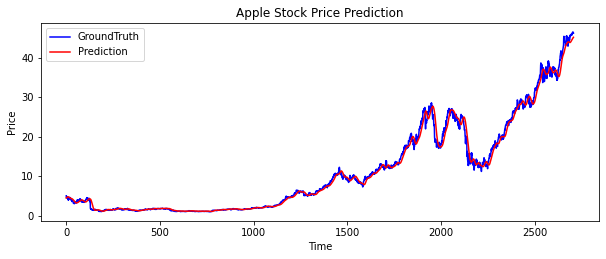

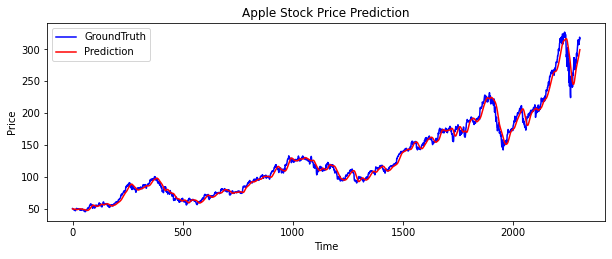

In [33]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Problem: 이번에는 종목을 바꿔서 삼성전자(종목코드 005930.KS) 주식 2000년 1월 1일부터 2010년 12월 31일까지 주가를 학습데이터로 활용하고 2011년 1월 1일부터 2020년 5월 22일까지 주가를 테스트데이터로 활용해서 주가를 예측해 보세요. 이번 과제는 얼마나 잘 예측하는지 랭킹을 매겨서 공개할 예정입니다. 여러분만의 획기적인 주가 예측 모델을 기대해 봅니다.

In [0]:
### START CODE HERE ###
### START COD
df_train = pdr.DataReader('005930.KS', 'yahoo', datetime(2000,1,1), datetime(2010,12,31))
df_test = pdr.DataReader('005930.KS', 'yahoo', datetime(2011,1,1), datetime(2020,5,22))
### END CODE HERE ###

training_set = df_train.iloc[:, 3:4].values
test_set = df_test.iloc[:, 3:4].values
#training_set.shape, test_set.shape
#assert training_set.shape == (2767,1)
#assert test_set.shape == (2363,1)
### END CODE HERE ###

In [35]:
training_set.shape

(2812, 1)

In [36]:
test_set.shape

(2258, 1)

Text(0, 0.5, 'price($)')

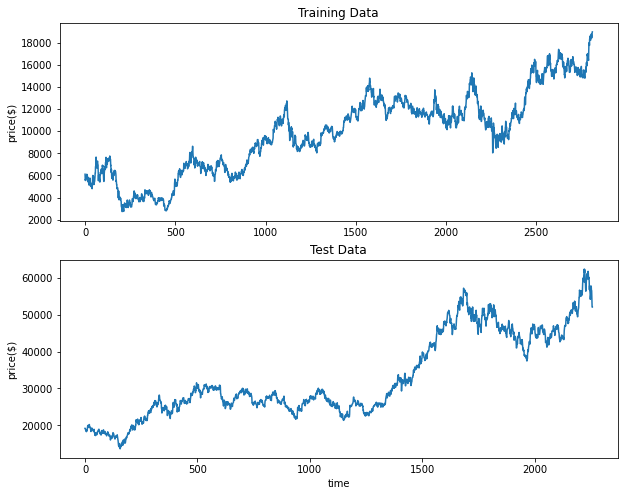

In [37]:
plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set)
plt.title("Training Data")
plt.ylabel('price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('price($)')

Text(0, 0.5, 'scaled price($)')

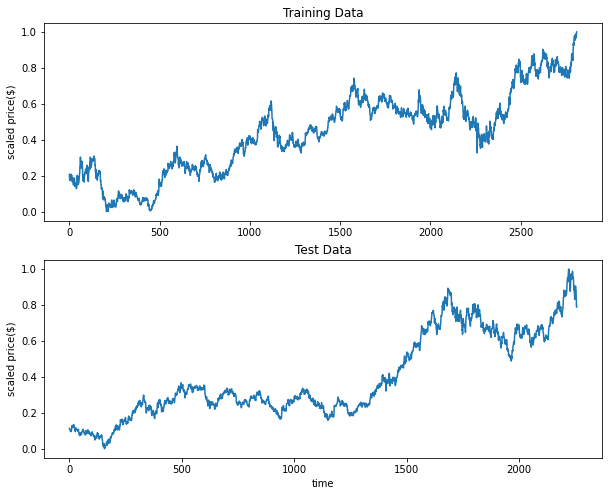

In [38]:
sc1 = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc1.fit_transform(training_set)
sc2 = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc2.fit_transform(test_set)

plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set_scaled)
plt.title("Training Data")
plt.ylabel('scaled price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set_scaled)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('scaled price($)')

In [0]:
X_train = []
Y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
Y_test = []
for i in range(60, test_set_scaled.shape[0]):
    X_test.append(test_set_scaled[i-60:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [40]:
X_train.shape, X_test.shape

((2752, 60, 1), (2198, 60, 1))

In [0]:
# scikit-learn의 GridSearchCV와 KerasClassifier 이용
import numpy
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
#Swish함수는 tf 2.1.0부터는 내장되어 있지만 2.0이하 model에서는 이렇게 function을 직접 생성한 후 사용해야 합니다.
def swish(x, beta = 1):
    return (x * tf.keras.backend.sigmoid(beta * x))
get_custom_objects().update({'swish': Activation(swish)})


def create_model(_optimizer,_ts, _lr, _batch_norm, _dropout):


    model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(_ts,input_shape = (60, 1),return_sequences=True),
                                    tf.keras.layers.Dropout(_dropout),

                                    
                                    tf.keras.layers.LSTM(_ts,return_sequences=True),
                                    tf.keras.layers.Dropout(_dropout),

                                    
                                    tf.keras.layers.LSTM(_ts,return_sequences=True),
                                    tf.keras.layers.Dropout(_dropout),

                                    
                                    tf.keras.layers.LSTM(_ts),
                                    tf.keras.layers.Dropout(_dropout),

                                    tf.keras.layers.Dense(1, activation= 'linear')
                                    #마지막 dense에 acitvation은 softmax

])
    optimizer = getattr(tf.keras.optimizers, _optimizer)(learning_rate=_lr)

    model.compile(loss='mean_squared_error',
              optimizer=optimizer,metrics=["accuracy"])

    return model

# KerasClassifier로 모델 생성기 설정
model = KerasClassifier(build_fn=create_model, verbose=3)

In [0]:
# Grid 설정
param_grid = {
    '_optimizer': ['RMSprop','Adam'], 
    '_ts' : [40, 50, 60],
    '_lr': [1e-2], 
    '_batch_norm': [1, 0], 
    '_dropout': [0.2, 0.4], 
}

In [44]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, Y_train,
                       #loss = 'mean_squared_error',
                       validation_data=(X_test, Y_test),
                       epochs = 15
                       
                       ) #Grid Search 학습

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/1

In [45]:
print(grid.best_score_)
print(grid.best_params_)

0.0025417574991782508
{'_batch_norm': 1, '_dropout': 0.2, '_lr': 0.01, '_optimizer': 'RMSprop', '_ts': 40}


In [46]:

import tensorflow as tf


### START CODE HERE ###
ss_model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(40,input_shape = (60, 1),return_sequences=True),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.2),

                                    
                                    tf.keras.layers.LSTM(40,return_sequences=True),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.2),

                                    
                                    tf.keras.layers.LSTM(40,return_sequences=True),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.2),

                                    
                                    tf.keras.layers.LSTM(40),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Dense(1, activation= 'linear')
         

])


### END CODE HERE ###

ss_model.summary()

Model: "sequential_244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_296 (LSTM)              (None, 60, 40)            6720      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 40)            160       
_________________________________________________________________
dropout_976 (Dropout)        (None, 60, 40)            0         
_________________________________________________________________
lstm_297 (LSTM)              (None, 60, 40)            12960     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 40)            160       
_________________________________________________________________
dropout_977 (Dropout)        (None, 60, 40)            0         
_________________________________________________________________
lstm_298 (LSTM)              (None, 60, 40)         

In [48]:

ss_model.compile(loss='mean_squared_error',
              optimizer="RMSprop",metrics=["accuracy"])
ss_model.fit(X_train, Y_train,
                       #loss = 'mean_squared_error',
                       validation_data=(X_test, Y_test),
                       epochs = 15
                       )


Epoch 1/15
86/86 [==============================] - 3s 34ms/step - loss: 0.0556 - accuracy: 7.2674e-04 - val_loss: 0.0621 - val_accuracy: 4.5496e-04
Epoch 2/15
86/86 [==============================] - 2s 20ms/step - loss: 0.0132 - accuracy: 7.2674e-04 - val_loss: 0.0430 - val_accuracy: 4.5496e-04
Epoch 3/15
86/86 [==============================] - 2s 19ms/step - loss: 0.0085 - accuracy: 7.2674e-04 - val_loss: 0.0449 - val_accuracy: 9.0992e-04
Epoch 4/15
86/86 [==============================] - 2s 20ms/step - loss: 0.0069 - accuracy: 7.2674e-04 - val_loss: 0.0287 - val_accuracy: 9.0992e-04
Epoch 5/15
86/86 [==============================] - 2s 19ms/step - loss: 0.0067 - accuracy: 7.2674e-04 - val_loss: 0.0240 - val_accuracy: 9.0992e-04
Epoch 6/15
86/86 [==============================] - 2s 19ms/step - loss: 0.0055 - accuracy: 7.2674e-04 - val_loss: 0.0233 - val_accuracy: 9.0992e-04
Epoch 7/15
86/86 [==============================] - 2s 19ms/step - loss: 0.0053 - accuracy: 7.2674e-04 - v

In [50]:
sc1 = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc1.fit_transform(training_set)
sc2 = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc2.fit_transform(test_set)


predicted_X_train = ss_model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = ss_model.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[59:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[59:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 500.48167117806366
평균 test error: 1485.0949949172543


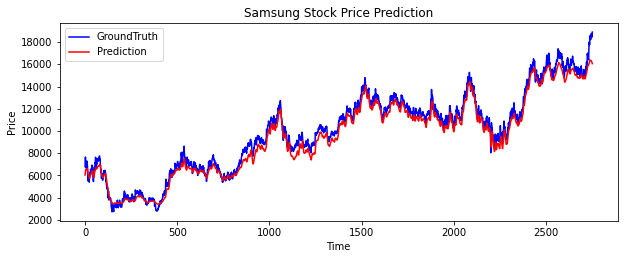

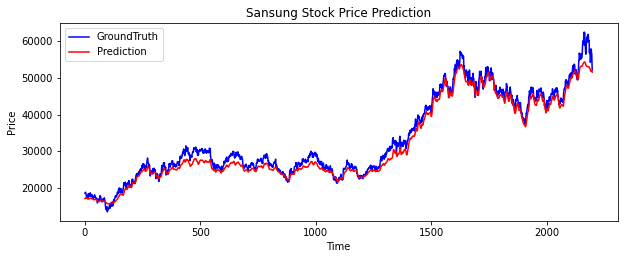

In [52]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Samsung Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Sansung Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Samsung 주식 예측은 "Samsung_stock_prediction"notebook으로 따로 작성하였습니다.
최종 test error는 135입니다.